In [38]:
import pandas as pd
import numpy as np



In [39]:
import requests


def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    Parameters:
    - endpoint: The endpoint of the API you want to
    make a GET request to.
    - payload: A dictionary of data to pass along
    with the request.
    Returns:
    Response object.
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': 'okLYyZLRxNYraHblJuPAMCyTSciFZzeN'
        },
        params=payload
    )

In [40]:
response = make_request('datasets', {'startdate':'2018-10-01'})
response.status_code

200

In [41]:
response.json().keys()

dict_keys(['metadata', 'results'])

In [42]:
response.json()['metadata']

{'resultset': {'offset': 1, 'count': 11, 'limit': 25}}

In [43]:
response.json()['results'][0].keys()


dict_keys(['uid', 'mindate', 'maxdate', 'name', 'datacoverage', 'id'])

In [44]:
[(data['id'], data['name']) for data in response.json()['results']]

[('GHCND', 'Daily Summaries'),
 ('GSOM', 'Global Summary of the Month'),
 ('GSOY', 'Global Summary of the Year'),
 ('NEXRAD2', 'Weather Radar (Level II)'),
 ('NEXRAD3', 'Weather Radar (Level III)'),
 ('NORMAL_ANN', 'Normals Annual/Seasonal'),
 ('NORMAL_DLY', 'Normals Daily'),
 ('NORMAL_HLY', 'Normals Hourly'),
 ('NORMAL_MLY', 'Normals Monthly'),
 ('PRECIP_15', 'Precipitation 15 Minute'),
 ('PRECIP_HLY', 'Precipitation Hourly')]

In [45]:
# get data category id
response = make_request(
'datacategories',
payload={
'datasetid' : 'GHCND'
}
)
response.status_code

200

In [46]:
response.json()['results']


[{'name': 'Evaporation', 'id': 'EVAP'},
 {'name': 'Land', 'id': 'LAND'},
 {'name': 'Precipitation', 'id': 'PRCP'},
 {'name': 'Sky cover & clouds', 'id': 'SKY'},
 {'name': 'Sunshine', 'id': 'SUN'},
 {'name': 'Air Temperature', 'id': 'TEMP'},
 {'name': 'Water', 'id': 'WATER'},
 {'name': 'Wind', 'id': 'WIND'},
 {'name': 'Weather Type', 'id': 'WXTYPE'}]

In [47]:
# get data type id
response = make_request(
'datatypes',
payload={
'datacategoryid' : 'TEMP',
'limit' : 100
}
)
response.status_code

200

In [48]:
[(datatype['id'], datatype['name']) for datatype in response.json()['results']][-5:] # look at the last 5Out[10]:


[('MNTM', 'Monthly mean temperature'),
 ('TAVG', 'Average Temperature.'),
 ('TMAX', 'Maximum temperature'),
 ('TMIN', 'Minimum temperature'),
 ('TOBS', 'Temperature at the time of observation')]

In [49]:
# get location category id
response = make_request(
'locationcategories',
{
'datasetid' : 'GHCND'
}
)
response.status_code

200

In [50]:
import pprint
pprint.pprint(response.json())


{'metadata': {'resultset': {'count': 12, 'limit': 25, 'offset': 1}},
 'results': [{'id': 'CITY', 'name': 'City'},
             {'id': 'CLIM_DIV', 'name': 'Climate Division'},
             {'id': 'CLIM_REG', 'name': 'Climate Region'},
             {'id': 'CNTRY', 'name': 'Country'},
             {'id': 'CNTY', 'name': 'County'},
             {'id': 'HYD_ACC', 'name': 'Hydrologic Accounting Unit'},
             {'id': 'HYD_CAT', 'name': 'Hydrologic Cataloging Unit'},
             {'id': 'HYD_REG', 'name': 'Hydrologic Region'},
             {'id': 'HYD_SUB', 'name': 'Hydrologic Subregion'},
             {'id': 'ST', 'name': 'State'},
             {'id': 'US_TERR', 'name': 'US Territory'},
             {'id': 'ZIP', 'name': 'Zip Code'}]}


In [54]:
def get_item(name, what, endpoint, start=1, end=None):
    """
    Perform a binary search to locate an item by name within a given dataset.

    Parameters:
    - name (str): The name of the item to search for.
    - what (dict): A dictionary specifying filters or other properties for the item.
    - endpoint (str): The API endpoint to search against.
    - start (int): Starting index for the search. Used in recursive calls.
    - end (int): Ending index for the search. Calculated dynamically if not provided.

    Returns:
    dict: Information about the found item, or an empty dictionary if not found.
    """
    # Find the midpoint, used to split data range for binary search
    mid = (start + (end if end else 1)) // 2

    # Lowercase the name for case-insensitive search
    name = name.lower()

    # Define the payload for the API request, setting offset to `mid`
    payload = {
        'datasetid': 'GHCND',
        'sortfield': 'name',
        'offset': mid,  # Change offset with each call
        'limit': 1      # Request one item per call
    }

    # Make the API request, merging `what` filters into the payload
    response = make_request(endpoint, {**payload, **what})

    if response.ok:
        # On first successful response, set `end` to the total count of results
        end = end if end else response.json()['metadata']['resultset']['count']

        # Get the current name from the response in lowercase for comparison
        current_name = response.json()['results'][0]['name'].lower()

        # If the item name matches the search name, return the item information
        if name in current_name:
            return response.json()['results'][0]

        # Recursive search adjustments
        elif start >= end:
            return {}  # Base case: item not found within the range
        elif name < current_name:
            # Search left half if the target name is alphabetically before current name
            return get_item(name, what, endpoint, start, mid - 1)
        else:
            # Search right half if the target name is alphabetically after current name
            return get_item(name, what, endpoint, mid + 1, end)
    else:
        # Log if response is not successful
        print(f'Response not OK, status: {response.status_code}')
        return {}

def get_location(name):
    """
    Retrieve location data for a city by name using binary search.

    Parameters:
    - name (str): The name of the city to search for.

    Returns:
    dict: Information about the city if found, otherwise an empty dictionary.
    """
    return get_item(name, {'locationcategoryid': 'CITY'}, 'locations')


In [55]:
def get_location(name):
  return get_item(name, {'locationcategoryid': 'CITY'}, 'locations')

In [57]:
nyc = get_location('New York')
nyc


{'mindate': '1869-01-01',
 'maxdate': '2024-11-01',
 'name': 'New York, NY US',
 'datacoverage': 1,
 'id': 'CITY:US360019'}

In [58]:
central_park = get_item('NY City Central Park', {'locationid' : nyc['id']}, 'stations')
central_park

{'elevation': 42.7,
 'mindate': '1869-01-01',
 'maxdate': '2024-10-30',
 'latitude': 40.77898,
 'name': 'NY CITY CENTRAL PARK, NY US',
 'datacoverage': 1,
 'id': 'GHCND:USW00094728',
 'elevationUnit': 'METERS',
 'longitude': -73.96925}

In [59]:
# get NYC daily summaries data
response = make_request(
'data',
{
'datasetid' : 'GHCND',
'stationid' : central_park['id'],
'locationid' : nyc['id'],
'startdate' : '2018-10-01',
'enddate' : '2018-10-31',
'datatypeid' : ['TMIN', 'TMAX', 'TOBS'], # temperature at time of observation, min, and max
'units' : 'metric',
'limit' : 1000
}
)
response.status_code

200

In [61]:
import pandas as pd

df = pd.DataFrame(response.json()['results'])
df.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",24.4
1,2018-10-01T00:00:00,TMIN,GHCND:USW00094728,",,W,2400",17.2
2,2018-10-02T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",25.0
3,2018-10-02T00:00:00,TMIN,GHCND:USW00094728,",,W,2400",18.3
4,2018-10-03T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",23.3


In [66]:
df.datatype.unique()

array(['TMAX', 'TMIN'], dtype=object)

In [69]:
if get_item('NY City Central Park', {'locationid' : nyc['id'], 'datatypeid': 'TOBS'}, 'stations'):
  print('Found!')
else:
  print('Not Found!')

Found!


In [70]:
laguardia = get_item(
'LaGuardia', {'locationid' : nyc['id']}, 'stations'
)
laguardia


{'elevation': 3,
 'mindate': '1939-10-07',
 'maxdate': '2024-10-31',
 'latitude': 40.77945,
 'name': 'LAGUARDIA AIRPORT, NY US',
 'datacoverage': 1,
 'id': 'GHCND:USW00014732',
 'elevationUnit': 'METERS',
 'longitude': -73.88027}

In [72]:
# get NYC daily summaries data
response = make_request(
'data',
{
'datasetid' : 'GHCND',
'stationid' : laguardia['id'],
'locationid' : nyc['id'],
'startdate' : '2018-10-01',
'enddate' : '2018-10-31',
'datatypeid' : ['TMIN', 'TMAX', 'TAVG'], # temperature at time of observation, min, and max
'units' : 'metric',
'limit' : 1000
}
)
response.status_code

200

In [73]:
df = pd.DataFrame(response.json()['results'])
df.head()


,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
1,2018-10-01T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2,2018-10-01T00:00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
3,2018-10-02T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
4,2018-10-02T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


In [74]:
df.datatype.value_counts()

,count
datatype,
TAVG,31
TMAX,31
TMIN,31


In [76]:
df.to_csv('nyc_temperatures1.csv', index=False)


In [78]:
df = pd.read_csv('nyc_temperatures1.csv')
df.head()


,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
1,2018-10-01T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2,2018-10-01T00:00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
3,2018-10-02T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
4,2018-10-02T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


In [79]:
df.columns

Index(['date', 'datatype', 'station', 'attributes', 'value'], dtype='object')

In [80]:
df.rename(
columns={
'value' : 'temp_C',
'attributes' : 'flags'
}, inplace=True
)

In [81]:
df.columns

Index(['date', 'datatype', 'station', 'flags', 'temp_C'], dtype='object')

In [82]:
df.rename(str.upper, axis='columns').columns


Index(['DATE', 'DATATYPE', 'STATION', 'FLAGS', 'TEMP_C'], dtype='object')

In [86]:
df.dtypes

,0
date,object
datatype,object
station,object
flags,object
temp_C,float64


In [87]:
df.loc[:,'date'] = pd.to_datetime(df.date)
df.dtypes

,0
date,object
datatype,object
station,object
flags,object
temp_C,float64


In [88]:
df.date.describe()

<ipython-input-88-f7d3fa946723>:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df.date.describe()


,date
count,93
unique,31
top,2018-10-01 00:00:00
freq,3


In [89]:
pd.date_range(start='2018-10-25', periods=2, freq='D').tz_localize('EST')

DatetimeIndex(['2018-10-25 00:00:00-05:00', '2018-10-26 00:00:00-05:00'], dtype='datetime64[ns, EST]', freq=None)

In [91]:
eastern = pd.read_csv(
'nyc_temperatures1.csv', index_col='date', parse_dates=True
).tz_localize('EST')
eastern.head()

,datatype,station,attributes,value
date,,,,
2018-10-01 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 00:00:00-05:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


In [92]:
eastern.tz_convert('UTC').head()

,datatype,station,attributes,value
date,,,,
2018-10-01 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 05:00:00+00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


In [93]:
eastern.to_period('M').index

<ipython-input-93-34a82283fe40>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  eastern.to_period('M').index


PeriodIndex(['2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-

In [94]:
eastern.to_period('M').to_timestamp().index


<ipython-input-94-22abc5f95bfc>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  eastern.to_period('M').to_timestamp().index


DatetimeIndex(['2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
      

In [96]:
df = pd.read_csv('nyc_temperatures1.csv').rename(
columns={
'value' : 'temp_C',
'attributes' : 'flags'
}
)
new_df = df.assign(
date=pd.to_datetime(df.date),
temp_F=(df.temp_C * 9/5) + 32
)
new_df.dtypes


,0
date,datetime64[ns]
datatype,object
station,object
flags,object
temp_C,float64
temp_F,float64


In [97]:
new_df.head()

,date,datatype,station,flags,temp_C,temp_F
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,70.16
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,78.08
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,64.94
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,72.86
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,78.98


In [98]:
df = df.assign(
date=pd.to_datetime(df.date),
temp_C_whole=df.temp_C.astype('int'),
temp_F=(df.temp_C * 9/5) + 32,
temp_F_whole=lambda x: x.temp_F.astype('int')
)
df.head()


,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


In [99]:
df_with_categories = df.assign(
station=df.station.astype('category'),
datatype=df.datatype.astype('category')
)
df_with_categories.dtypes

,0
date,datetime64[ns]
datatype,category
station,category
flags,object
temp_C,float64
temp_C_whole,int64
temp_F,float64
temp_F_whole,int64


In [100]:
pd.Categorical(
['med', 'med', 'low', 'high'],
categories=['low', 'med', 'high'],
ordered=True
)

['med', 'med', 'low', 'high']
Categories (3, object): ['low' < 'med' < 'high']

In [101]:
df.sort_values(by='temp_C', ascending=False).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
27,2018-10-10,TAVG,GHCND:USW00014732,"H,,S,",23.8,23,74.84,74
30,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74


In [102]:
df.sort_values(by=['temp_C', 'date'], ascending=False).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
27,2018-10-10,TAVG,GHCND:USW00014732,"H,,S,",23.8,23,74.84,74
30,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74


In [103]:
df.nlargest(n=5, columns='temp_C')

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


In [105]:
df.nsmallest(n=5, columns=['temp_C', 'date'])

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
65,2018-10-22,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
77,2018-10-26,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
62,2018-10-21,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
74,2018-10-25,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
53,2018-10-18,TMIN,GHCND:USW00014732,",,W,2400",6.7,6,44.06,44


In [106]:
df.sample(5, random_state=0).index

Index([2, 30, 55, 16, 13], dtype='int64')

In [107]:
df.sample(5, random_state=0).sort_index().index

Index([2, 13, 16, 30, 55], dtype='int64')

In [108]:
df.sort_index(axis=1).head()

,datatype,date,flags,station,temp_C,temp_C_whole,temp_F,temp_F_whole
0,TAVG,2018-10-01,"H,,S,",GHCND:USW00014732,21.2,21,70.16,70
1,TMAX,2018-10-01,",,W,2400",GHCND:USW00014732,25.6,25,78.08,78
2,TMIN,2018-10-01,",,W,2400",GHCND:USW00014732,18.3,18,64.94,64
3,TAVG,2018-10-02,"H,,S,",GHCND:USW00014732,22.7,22,72.86,72
4,TMAX,2018-10-02,",,W,2400",GHCND:USW00014732,26.1,26,78.98,78


In [109]:
df.sort_index(axis=1).head().loc[:,'temp_C':'temp_F_whole']

,temp_C,temp_C_whole,temp_F,temp_F_whole
0,21.2,21,70.16,70
1,25.6,25,78.08,78
2,18.3,18,64.94,64
3,22.7,22,72.86,72
4,26.1,26,78.98,78


In [110]:
df.equals(df.sort_values(by='temp_C'))

False

In [111]:
df.equals(df.sort_values(by='temp_C').sort_index())

True

In [112]:
df[df.datatype == 'TAVG'].head().reset_index()

,index,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
1,3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
2,6,2018-10-03,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
3,9,2018-10-04,TAVG,GHCND:USW00014732,"H,,S,",21.3,21,70.34,70
4,12,2018-10-05,TAVG,GHCND:USW00014732,"H,,S,",20.3,20,68.54,68


In [113]:
df.set_index('date', inplace=True)
df.head()

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


In [114]:
df['2018-10-11':'2018-10-12']


,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


##Data Analysis of NYC Temperatures


In [132]:
import matplotlib.pyplot as plt

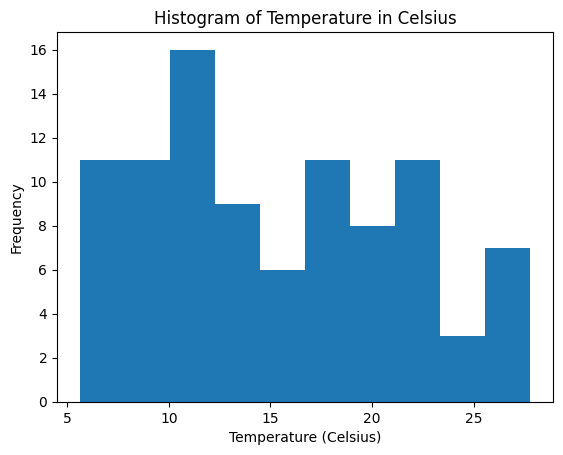

In [133]:
#Summary measures for Temperature in Celsius
df['temp_C'].describe()

plt.hist(df['temp_C'])
plt.title('Histogram of Temperature in Celsius')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Frequency')
plt.show()

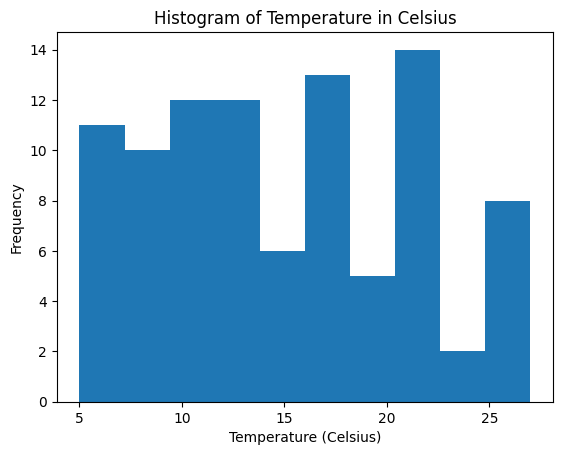

In [134]:
#Summary measures for Temperature in Celsius (Whole)
df['temp_C_whole'].describe()

plt.hist(df['temp_C_whole'])
plt.title('Histogram of Temperature in Celsius')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Frequency')
plt.show()

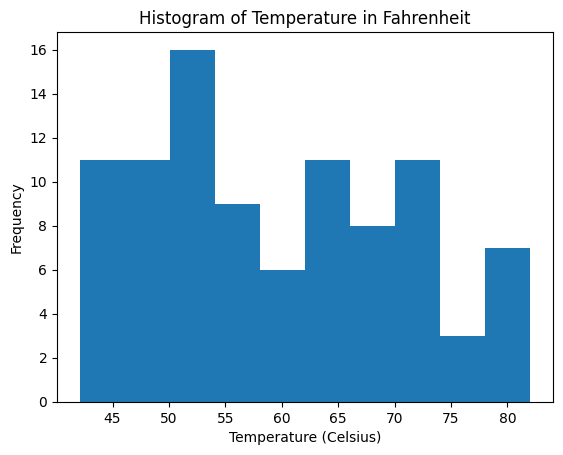

In [135]:
#Summary measures for Temperature in Fahrenheit
df['temp_F'].describe()

plt.hist(df['temp_F'])
plt.title('Histogram of Temperature in Fahrenheit')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Frequency')
plt.show()

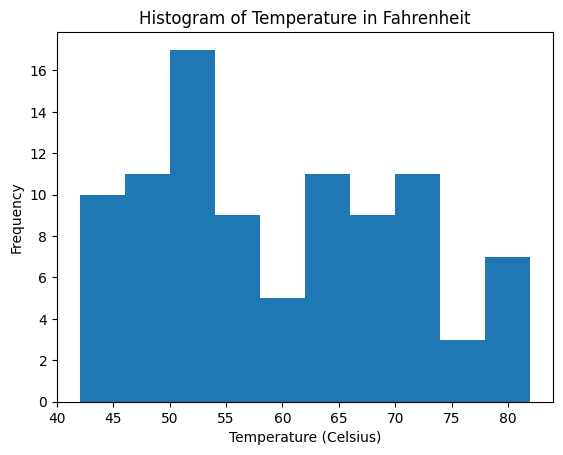

In [136]:
#Summary measures for Temperature in Fahrenheit (whole)
df['temp_F_whole'].describe()

plt.hist(df['temp_F_whole'])
plt.title('Histogram of Temperature in Fahrenheit')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Frequency')
plt.show()

In [130]:
iqr = 21.10 - 10.20
print(f"The Interquartile range is {round(iqr, 2)} degrees Celsius")
iqr = 21 - 10
print(f"The Interquartile range is {round(iqr, 2)} degrees Celsius (whole)")
iqr = 69.98 - 50.36
print(f"The Interquartile range is {round(iqr, 2)} degrees Fahrenheit")
iqr = 69 - 50
print(f"The Interquartile range is {round(iqr, 2)} degrees Fahrenheit (whole)")

The Interquartile range is 10.9 degrees Celsius
The Interquartile range is 11 degrees Celsius (whole)
The Interquartile range is 19.62 degrees Fahrenheit
The Interquartile range is 19 degrees Fahrenheit (whole)
